PROCESSING

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Validate and Split Exported TFRecords" data-toc-modified-id="Validate and Split Exported TFRecords-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Validate and Split Exported TFRecords</a></span></li><li><span><a href="#Inspecting a single tfrecord file" data-toc-modified-id="Inspecting a single tfrecord file-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Inspecting a single tfrecord file</a></span></li><li><span><a href="#Calculate Mean and Std-Dev for Each Band" data-toc-modified-id="Calculate Mean and Std-Dev for Each Band-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate Mean and Std-Dev for Each Band</a></span></li></ul></div>

## Pre-requisites

Go through the ```preprocessing/0_export_tfrecords.ipynb``` notebook.

Before running this notebook, you should have the following structure under the data/ directory:

```
data/
    idhm_tfrecords_raw/
        ADRIANOPOLIS_2010_00.tfrecord.gz
        ...
        ADRIANOPOLIS_2010_21.tfrecord.gz
        ...
        TAPIRAI_2010_14.tfrecord.gz
```


##Instructions

This notebook processes the exported TFRecords as follows:

1. Verifies that the fields in the TFRecords match the original CSV files.
2. Splits each monolithic TFRecord file exported from Google Earth Engine into one file per record.

After running this notebook, you should have a new folder ```(idhm_tfrecords)``` under data/:

```
data/
    idhm_tfrecords/
        ADRIANOPOLIS_2010
          0000.tfrecord.gz
          ...
          0021.tfrecord.gz
        ...
        TAPIRAI_2010
          0000.tfrecord.gz
          ...
          0014.tfrecord.gz
```
This notebook also inspects a single tf record file (structure comprehension reasons)

Finally, it also calculates the mean and standard deviation of each band



##Imports and Constants


In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# remember to mount if in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from __future__ import annotations

from collections.abc import Iterable
import glob
from pprint import pprint
import os
from typing import Optional

import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from tqdm.auto import tqdm

from natsort import natsorted 

In [3]:
REQUIRED_BANDS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'NIGHTLIGHTS', 'NIR', 'RED',
    'SWIR1', 'SWIR2', 'TEMP1']

BANDS_ORDER = [
    'BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR',
    'DMSP', 'VIIRS']

EXPORT_FOLDER = '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_raw_2'

PROCESSED_FOLDER = '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2'

## Validate and Split Exported TFRecords


In [ ]:

def process_dataset(csv_path: str, input_dir: str, processed_dir: str) -> None:
    '''
    Args
    - csv_path: str, path to CSV of DHS or LSMS clusters
    - input_dir: str, path to TFRecords exported from Google Earth Engine
    - processed_dir: str, folder where to save processed TFRecords
    '''
    df = pd.read_csv(csv_path, float_precision='high', index_col=False)
    surveys = list(df.groupby(['group', 'year']).groups.keys())  # (state, year) tuples

    for group, year in surveys:
        group_year = f'{group}_{year}'
        print('Processing:', group_year)

        tfrecord_paths = glob.glob(os.path.join(input_dir, group_year + '*'))
        tfrecord_paths = natsorted(tfrecord_paths)
        
        out_dir = os.path.join(processed_dir, group_year)
        os.makedirs(out_dir, exist_ok=True)
        subset_df = df[(df['group'] == group) & (df['year'] == year)].reset_index(drop=True)
        validate_and_split_tfrecords(
            tfrecord_paths=tfrecord_paths, out_dir=out_dir, df=subset_df)

In [ ]:
def validate_and_split_tfrecords(
        tfrecord_paths: Iterable[str],
        out_dir: str,
        df: pd.DataFrame
        ) -> None:
    '''Validates and splits a list of exported TFRecord files (for a
    given country-year survey) into individual TFrecords, one per cluster.

    "Validating" a TFRecord comprises of 2 parts
    1) verifying that it contains the required bands
    2) verifying that its other features match the values from the dataset CSV

    Args
    - tfrecord_paths: list of str, paths to exported TFRecords files
    - out_dir: str, path to dir to save processed individual TFRecords
    - df: pd.DataFrame, index is sequential and starts at 0
    '''
    # Create an iterator over the TFRecords file. The iterator yields
    # the binary representations of Example messages as strings.
    options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)

    # cast float64 => float32 and str => bytes
    for col in df.columns:
        if df[col].dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        elif df[col].dtype == object:  # pandas uses 'object' type for str
            df[col] = df[col].astype(bytes)

    i = 0
    progbar = tqdm(total=len(df))


    for tfrecord_path in tfrecord_paths:
         iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)
         for record_str in iterator:
            # parse into an actual Example message
            ex = tf.train.Example.FromString(record_str)
            feature_map = ex.features.feature

            # verify required bands exist
            for band in REQUIRED_BANDS:
                assert band in feature_map, f'Band "{band}" not in record {i} of {tfrecord_path}'

            # compare feature map values against CSV values
            csv_feats = df.loc[i, :].to_dict()
            for col, val in csv_feats.items():
                ft_type = feature_map[col].WhichOneof('kind')
                ex_val = feature_map[col].__getattribute__(ft_type).value[0]
                assert val == ex_val, f'Expected {col}={val}, but found {ex_val} instead'

            # serialize to string and write to file
            out_path = os.path.join(out_dir, f'{i:05d}.tfrecord.gz')  # all surveys have < 1e6 clusters
            with tf.io.TFRecordWriter(out_path, options=options) as writer:
                writer.write(ex.SerializeToString())

            i += 1
            progbar.update(1)
    progbar.close()

In [ ]:
process_dataset(
    csv_path='/content/drive/MyDrive/USP/TCC/data/vr_cluster_test.csv',
    input_dir=EXPORT_FOLDER,
    processed_dir=PROCESSED_FOLDER)

Processing: group1_2010


  0%|          | 0/320 [00:00<?, ?it/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Processing: group2_2010


  0%|          | 0/181 [00:00<?, ?it/s]

## Calculate Mean and Std-Dev for Each Band


The means and standard deviations calculated here are saved as constants in batchers/dataset_constants.py for _MEANS_IDHM, _STD_DEVS_IDHM


In [ ]:
%cd /content/drive/MyDrive/USP/TCC/code
from batchers import batcher, tfrecord_paths_utils
from helper import (
    analyze_tfrecord_batch,
    per_band_mean_std,
    print_analysis_results)

/content/drive/MyDrive/USP/TCC/code


In [ ]:
def calculate_mean_std(tfrecord_paths):
    '''Calculates and prints the per-band means and std-devs'''
    iter_init, batch_op = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        label_name=None,
        ls_bands='ms',
        nl_band='merge',
        batch_size=128,
        shuffle=False,
        augment=False,
        clipneg=False,
        normalize=None).get_batch()

    stats = analyze_tfrecord_batch(
        iter_init, batch_op, total_num_images=len(tfrecord_paths),
        nbands=len(BANDS_ORDER), k=10)
    means, stds = per_band_mean_std(stats=stats, band_order=BANDS_ORDER)

    print('Means:')
    pprint(means)
    print()

    print('Std Devs:')
    pprint(stds)

    print('\n========== Additional Per-band Statistics ==========\n')
    print_analysis_results(stats, BANDS_ORDER)

In [ ]:
calculate_mean_std(tfrecord_paths_utils.idhm())

glob_path /content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/*.tfrecord.gz
tfrecord_paths ['/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00000.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00001.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00002.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00003.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00004.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00005.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00006.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00007.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/group1_2010/00008.tfrecord.gz', '/content/drive/MyDrive/USP/TCC/data/images/idhm_tf

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.



Finished. Processed 501 images.
Time per batch - mean: 8.283s, std: 5.231s
Time to process each batch - mean: 5.481s, std: 3.042s
Total time: 55.312s, Num batches: 4
Means:
{'BLUE': 0.03783132738210275,
 'DMSP': 2.8460656780173728,
 'GREEN': 0.06399377716803702,
 'NIR': 0.26983322224558304,
 'RED': 0.06603825365115681,
 'SWIR1': 0.19816657278023195,
 'SWIR2': 0.10811002413360227,
 'TEMP1': 295.60011223090646,
 'VIIRS': 0.0}

Std Devs:
{'BLUE': 0.009661004876261819,
 'DMSP': 11.204740065880282,
 'GREEN': 0.01543489926269562,
 'NIR': 0.04837808482833679,
 'RED': 0.023551113891992465,
 'SWIR1': 0.05370598224397302,
 'SWIR2': 0.0399053692414233,
 'TEMP1': 1.3762731094767395,
 'VIIRS': 0.0}

========== Additional Per-band Statistics ==========

Statistics including bad pixels
Band BLUE     - mean:   0.037831, std:  0.009661, min:  0.00992245, max:    2.000000
Band GREEN    - mean:   0.063994, std:  0.015435, min:     0.01825, max:    0.517500
Band RED      - mean:   0.066038, std:  0.023551

/content/drive/MyDrive/USP/TCC/code/helper.py:187: RuntimeWarning: invalid value encountered in true_divide
  means = sums / nz_pixels
/content/drive/MyDrive/USP/TCC/code/helper.py:188: RuntimeWarning: invalid value encountered in true_divide
  stds = np.sqrt(sum_sqs/nz_pixels - means**2)


In [ ]:
%cd /content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2/

/content/drive/MyDrive/USP/TCC/data/images/idhm_tfrecords_2


## Inspecting a single tfrecord file

In [10]:
from utils.plot import plot_image_by_band 
from batchers import dataset_constants
from batchers import tfrecord_paths_utils
import matplotlib.pyplot as plt
import numpy as np

In [11]:
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
DATASET_NAME = 'IDHM'
MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

In [15]:
def inspecting_single_file(tfrecord_path):
  options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)
  iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)
  for record_str in iterator:
    # parse into an actual Example message
    ex = tf.train.Example.FromString(record_str)
    feature_map = ex.features.feature
  
    feature_types = {}
    for name in feature_map.keys():
      ft_type = feature_map[name].WhichOneof('kind')
      ft_shape = np.array(feature_map[name].__getattribute__(ft_type).value).shape
      feature_types[name] = (ft_type, ft_shape)

    return feature_map, feature_types

         

In [24]:
feature_map, feature_types = inspecting_single_file(tfrecord_paths_utils.idhm()[0])

In [25]:
def print_scalar_values(feature_map):
    '''Prints scalar values from a TFRecord feature map.
    Args
    - feature_map: protobuf map from feature name strings to Feature
    '''
    for name in sorted(feature_map.keys()):
        ft_type = feature_map[name].WhichOneof('kind')
        ft_shape = np.array(feature_map[name].__getattribute__(ft_type).value).shape
        if ft_type == 'float_list' and ft_shape == (1,):
            value = feature_map[name].float_list.value[0]
            print(f'{name}: {value}')
        elif ft_type == 'bytes_list' and ft_shape == (1,):
            value = feature_map[name].bytes_list.value[0].decode()
            print(f'{name}: {value}')

In [26]:
pprint(feature_types)
print('\n')
print_scalar_values(feature_map)

{'BLUE': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'IDHM': ('float_list', (1,)),
 'IncomeIDHM': ('float_list', (1,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'LiteracyIDHM': ('float_list', (1,)),
 'LongevityIDHM': ('float_list', (1,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'cell_id': ('float_list', (1,)),
 'geometry': ('bytes_list', (1,)),
 'group': ('bytes_list', (1,)),
 'lat': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'year': ('float_list', (1,))}


IDHM: 0.6754943132400513
IncomeIDHM: 0.6636301875114441
LiteracyIDHM: 0.5804125666618347
LongevityIDHM: 0.8017610311508179
cell_id: 2916.0
geometry: POINT (-51.27691448718255 -26.314128858279812)
group: group10
lat: -26.314128875732422
lon: -51.276912689208984
sy

Loc: (-26.314129, -51.276913), 2916.0, 2010


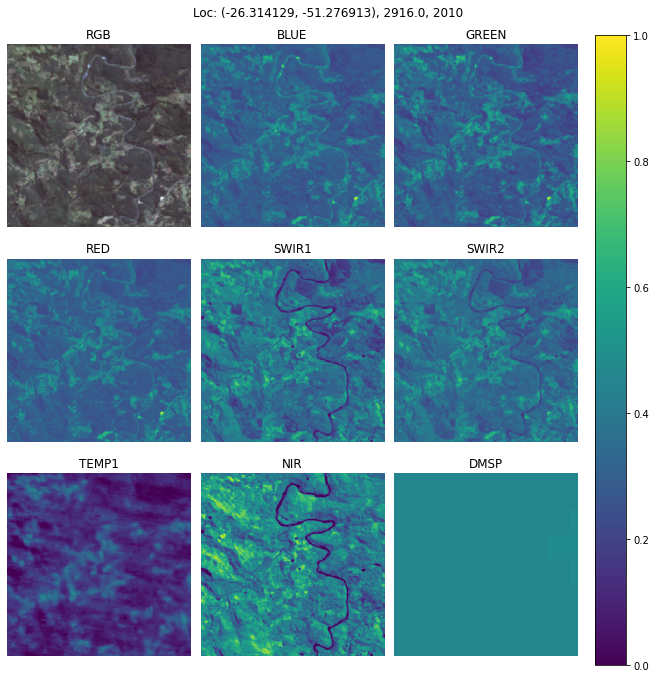

In [27]:
def year_to_nltype(year):
    return 'DMSP' if year < 2012 else 'VIIRS'

def band_keys_for_year(band_keys, year):
    '''
    Args
    - band_keys: list of str, including 'NIGHTLIGHTS'
    - year: numeric

    Returns
    - new_band_keys: copy of band_keys with 'NIGHTLIGHTS' replaced by 'DMSP' or 'VIIRS'
    '''
    new_band_keys = list(band_keys) # make a local copy
    new_band_keys[band_keys.index('NIGHTLIGHTS')] = year_to_nltype(year)
    return new_band_keys

def plot_single_img(feature_map):
    lat = np.float32(feature_map['lat'].float_list.value[0])
    lon = np.float32(feature_map['lon'].float_list.value[0])
    #municipality = feature_map['cell_id'].bytes_list.value[0].decode()
    municipality = np.float32(feature_map['cell_id'].float_list.value[0])
    year = int(feature_map['year'].float_list.value[0])
    fig_title = f'Loc: ({lat:.6f}, {lon:.6f}), {municipality}, {year}'
    print(fig_title)

    # choose 'DMSP' or 'VIIRS' for nightlights band name based on year
    band_keys_nl = band_keys_for_year(BAND_ORDER, year)

    img_normalized = []
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        b = band_keys_nl[b_idx]
        band = (band - MEANS[b]) / STD_DEVS[b]
        img_normalized.append(band)
    img_normalized = np.stack(img_normalized, axis=2)

    plot_image_by_band(img=img_normalized, band_order=band_keys_nl, nrows=3, title=fig_title,
                       rgb='add', colorbar=True)

plot_single_img(feature_map)